<a href="https://colab.research.google.com/github/IcanFei/Price-Prediction-of-Gold-and-Silver/blob/master/Silver_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0.1 Setup Environment**



## **0.1 Setup Google Drive Environment**

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## **0.2 Load Packages**

In [0]:
# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np
from math import sqrt
from numpy import log
from math import ceil 
from pandas import Series

# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ARIMA model 
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
# Using ADF(Augmented Dickey Fuller) test to identify whether the series is stationary or not 
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels as sm

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import date2num
import seaborn as sns
from datetime import datetime
import subprocess
# heatmap
import seaborn as sns

plt.rcParams['figure.figsize'] = [20,8] 

# **1. Data Extraction**




## **1.1 Prepare the data - Gold_2019 (2019-01-01 to 2019-11-12)**

In [0]:
# Load the data from google drive
link = 'https://drive.google.com/open?id=15o0p9ZpDjSXlvLzyo6S2OD3_c-IpjIfG'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # Replace the id with id of file I want to access
file.GetContentFile('Gold2019.csv')

In [0]:
# Read and check the data
G_2019 = pd.read_csv('Gold2019.csv')
G_2019.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Nov 12, 2019","1,453.70","1,455.90","1,461.30","1,446.20",429.61K,-0.23%
1,"Nov 11, 2019","1,457.10","1,460.00","1,467.40","1,448.90",310.16K,-0.40%
2,"Nov 08, 2019","1,462.90","1,469.00","1,473.90","1,457.00",447.07K,-0.24%
3,"Nov 07, 2019","1,466.40","1,492.10","1,493.60","1,461.40",674.98K,-1.79%
4,"Nov 06, 2019","1,493.10","1,484.30","1,495.90","1,483.80",313.72K,0.63%


In [0]:
#check the missing data
G_2019.isnull().any()

Date        False
Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

**Comment:** There is no missing data in G_2019


## **1.2 Prepare the data - Silver_2019 (2019-01-01 to 2019-11-12)**

In [0]:
# Load the data
link = 'https://drive.google.com/open?id=1oxbYtY27exKyW2Bm4UQPp5ebIr56_opl'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file I want to access
file.GetContentFile('Silver2019.csv') 

In [0]:
# Read and check the data
S_2019 = pd.read_csv('Silver2019.csv')
S_2019.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Nov 12, 2019",16.832,16.805,16.858,16.805,-,0.14%
1,"Nov 11, 2019",16.808,16.802,16.907,16.633,-,0.04%
2,"Nov 10, 2019",16.802,16.762,16.808,16.758,-,-0.12%
3,"Nov 08, 2019",16.823,17.070,17.095,16.660,135.57K,-1.10%
4,"Nov 07, 2019",17.010,17.605,17.645,16.910,166.41K,-3.34%


# **2. Data Processing**




In [0]:
# Change the format of "Data"
S_2019["Date"] = pd.to_datetime(S_2019["Date"]).dt.strftime('%Y-%m-%d')

# **3. Data Exploration**


## **3.1 Select Date Range and Commodity Type**

In [0]:
# Set up the function of selecting range of date and commodity type
def extract_data(start_date,end_date,commodity_type):
  if commodity_type == "Gold":
    return G_2019[(G_2019.Date>=start_date)&(G_2019.Date<=end_date)]
  elif commodity_type == "Silver":
    return S_2019[(S_2019.Date>=start_date)&(S_2019.Date<=end_date)]

In [0]:
# Specify users inputs, you can change the start date and end data to extract data from G-2019
# In this case, I select the data from 2019-01-01 to 2019-11-12 and gold as my input
start_date = "2019-01-01"
end_date = "2019-11-12"
commodity_type = "Silver"
df= extract_data(start_date, end_date, commodity_type);
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-11-12,16.832,16.805,16.858,16.805,-,0.14%
1,2019-11-11,16.808,16.802,16.907,16.633,-,0.04%
2,2019-11-10,16.802,16.762,16.808,16.758,-,-0.12%
3,2019-11-08,16.823,17.070,17.095,16.660,135.57K,-1.10%
4,2019-11-07,17.010,17.605,17.645,16.910,166.41K,-3.34%


## **3.2 Statistical Properties Descriptions**





Text(0.5,1,'Silver')

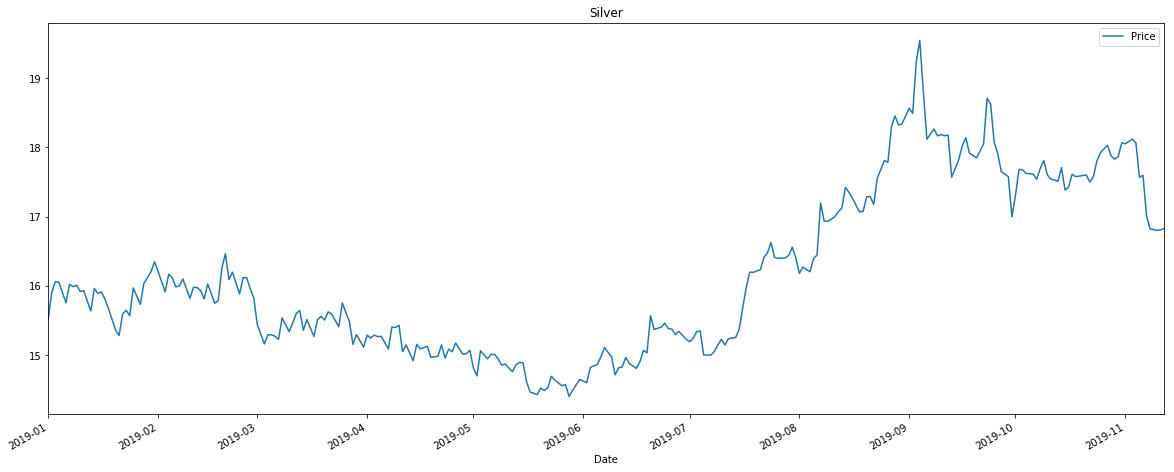

In [0]:
# Change "Date" as index and sort the data
df['Date'] =pd.to_datetime(df.Date)
df.sort_values('Date')

df.plot(x='Date',y='Price')
plt.title(commodity_type)

In [0]:
# The statistical properties of data
df.describe()

,Price,Open,High,Low
count,271.000000,271.000000,271.000000,271.000000
mean,16.156292,16.154952,16.275162,16.034192
std,1.192227,1.190881,1.245350,1.133965
min,14.401000,14.390000,14.428000,14.350000
25%,15.167000,15.207500,15.305000,15.099000
50%,15.892000,15.860000,15.925000,15.785000
75%,17.274500,17.255000,17.452500,17.027500
max,19.547000,19.645000,19.750000,19.280000


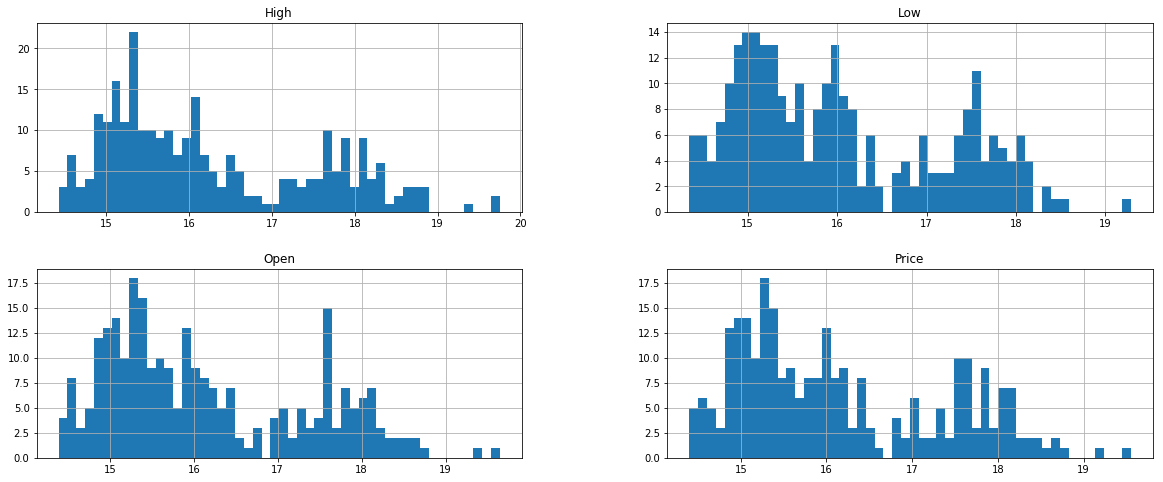

In [0]:
# Darw histgram of each column
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (20,8)
hist = df[["Price","High","Low","Open", 'Vol.', 'Change %']].hist(bins=50)

**Comment:** We can see price, high, low, open columns have similar distributions 

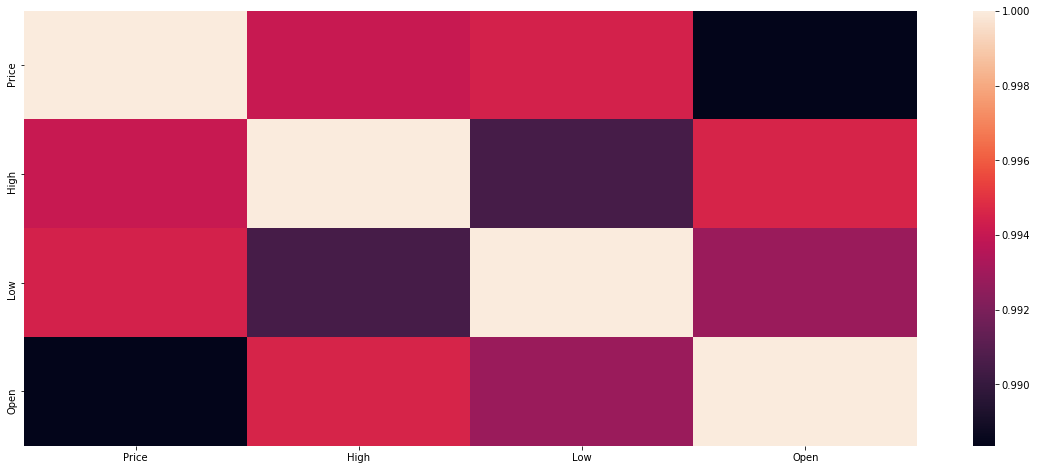

In [0]:
import seaborn as sns
# calculate the correlation matrix
corr = df[["Price","High","Low","Open"]].corr()
# plot the heatmap to show the correlations among different price columns 
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [0]:
# Check the correlation score
print (corr['Price'].sort_values(ascending=False), '\n')

(Price    1.000000
Low      0.994480
High     0.994078
Open     0.988354
Name: Price, dtype: float64, '\n')


## **3.3 Data Stationarity Test**

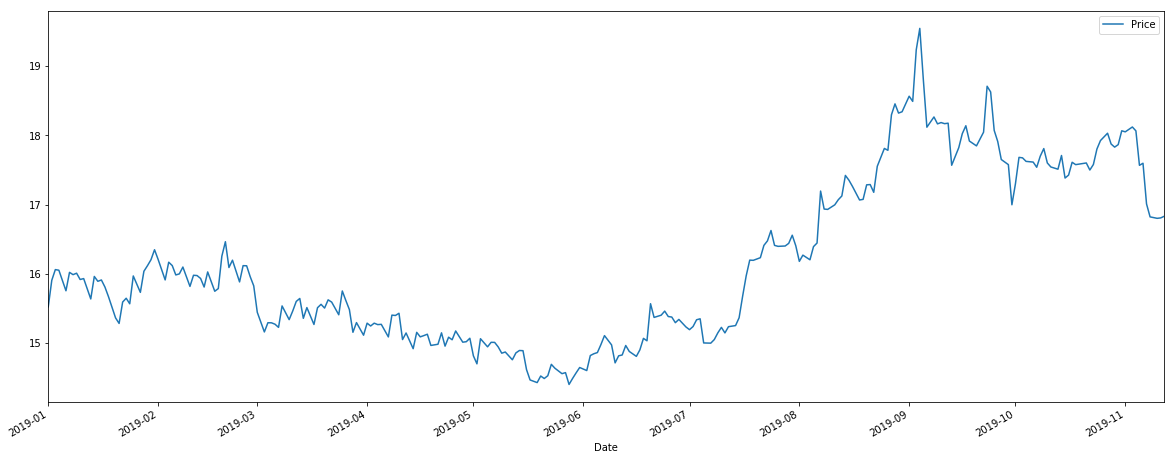

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,8)
df.plot(x='Date',y='Price')

In [0]:
# only take Price column 
df1=df[['Date','Price']]
# set date as index to make df series type 
df2 = df1.set_index('Date')['Price']
type(df2)

pandas.core.series.Series

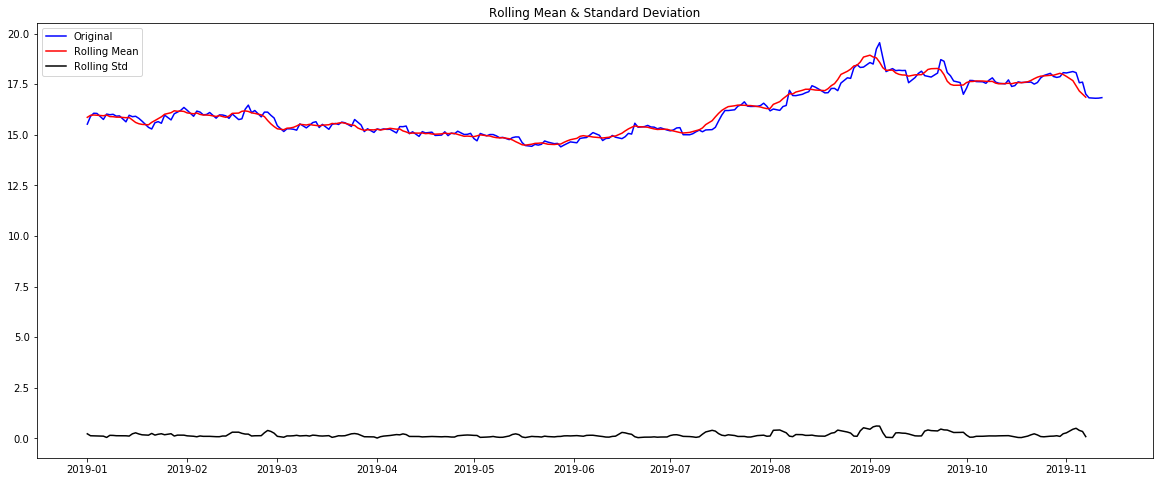

<Figure size 5760x720 with 0 Axes>

Results of Dickey-Fuller Test:
Test Statistic                  -1.315141
p-value                          0.622217
#Lags Used                      11.000000
Number of Observations Used    259.000000
Critical Value (5%)             -2.872765
Critical Value (1%)             -3.455853
Critical Value (10%)            -2.572752
dtype: float64


In [0]:
# Visualisation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [20,8]

# Using ADF(Augmented Dickey Fuller) test to identify whether the series is stationary or not 
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=5).mean() 
    rolstd = timeseries.rolling(window=5).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.figure(figsize=(80,10))
    plt.show(block=False)
    major_ticks = np.arange(0, 101, 20)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
test_stationarity(df2)

In this case, it is easy to see that the series is not stationary. P-Value of 0.622 is greater than our 5% significance level, therefore we fail to reject the null hypothesis that unit root does exist.

If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary). So we need to transform the data into stationary data


## **3.4 Data Stationarity Transformation**

### **3.4.1 Exponential average**

In [0]:
S_2019_S = df2

gg[link text](https://)

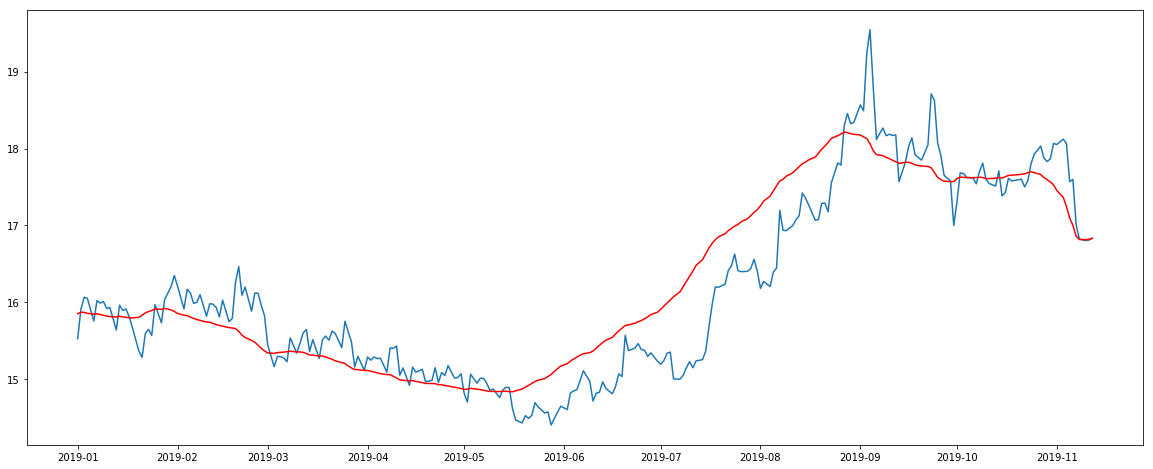

In [0]:
expwighted_avg = S_2019_S.ewm(halflife=12).mean()
plt.plot(S_2019_S.index, S_2019_S)
plt.plot(expwighted_avg, color='red')
plt.rcParams["figure.figsize"] = (20,8)

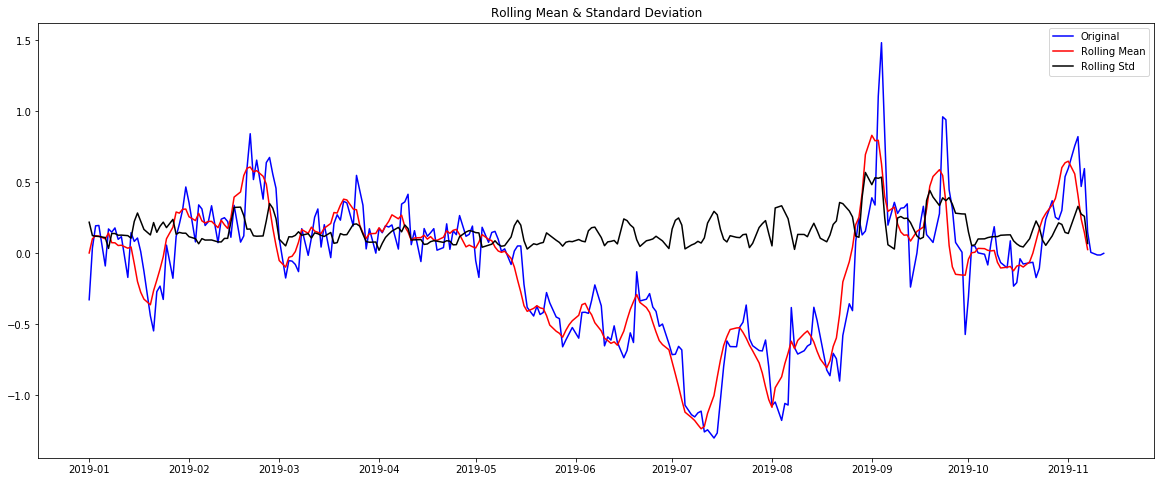

<Figure size 5760x720 with 0 Axes>

Results of Dickey-Fuller Test:
Test Statistic                  -1.948258
p-value                          0.309710
#Lags Used                      11.000000
Number of Observations Used    259.000000
Critical Value (5%)             -2.872765
Critical Value (1%)             -3.455853
Critical Value (10%)            -2.572752
dtype: float64


In [0]:
ewma_diff = S_2019_S - expwighted_avg
test_stationarity(ewma_diff)

For this exponential average method, the plot shows that rolling mean and rolling std still vary from May to August, but more stable in other months. We can see p-value is larger than 5%, meaning this difference between the exponential average and the actual price is still none-stationary data 

### **3.4.2 Differencing**

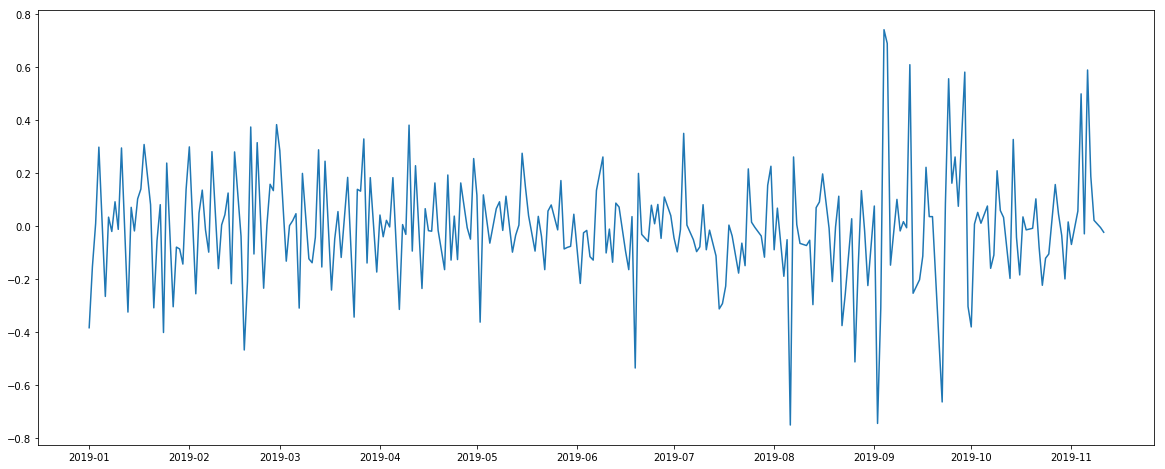

In [0]:
S_2019_S_diff = S_2019_S - S_2019_S.shift()
plt.plot(S_2019_S_diff)

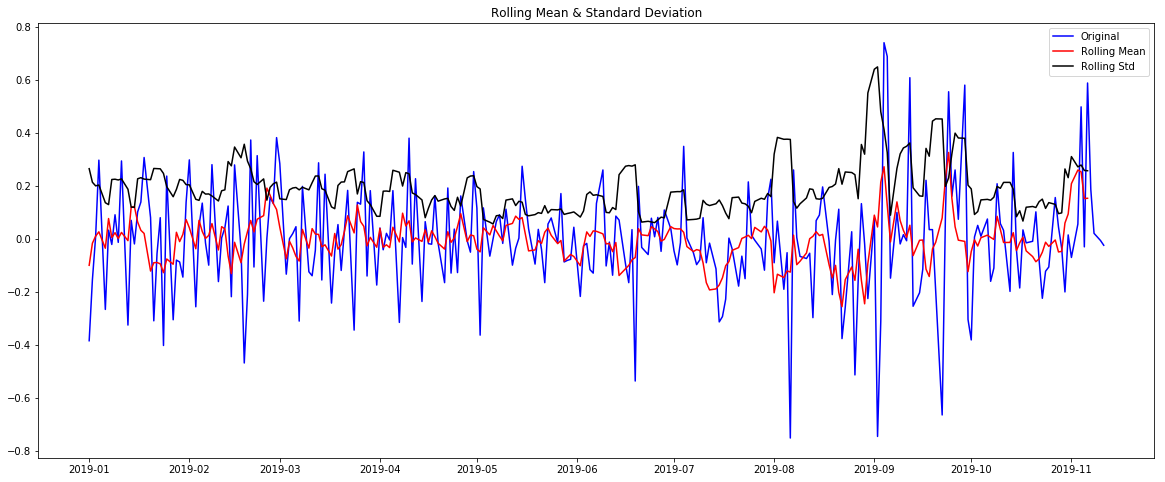

<Figure size 5760x720 with 0 Axes>

Results of Dickey-Fuller Test:
Test Statistic                  -5.351174
p-value                          0.000004
#Lags Used                      11.000000
Number of Observations Used    258.000000
Critical Value (5%)             -2.872809
Critical Value (1%)             -3.455953
Critical Value (10%)            -2.572775
dtype: float64


In [0]:
S_2019_S_diff.dropna(inplace=True)
test_stationarity(S_2019_S_diff)

We can see now p-value is smaller than 5%, meaning this df2_diff is converted to stationary data. 

### **3.4.3 Decomposing**

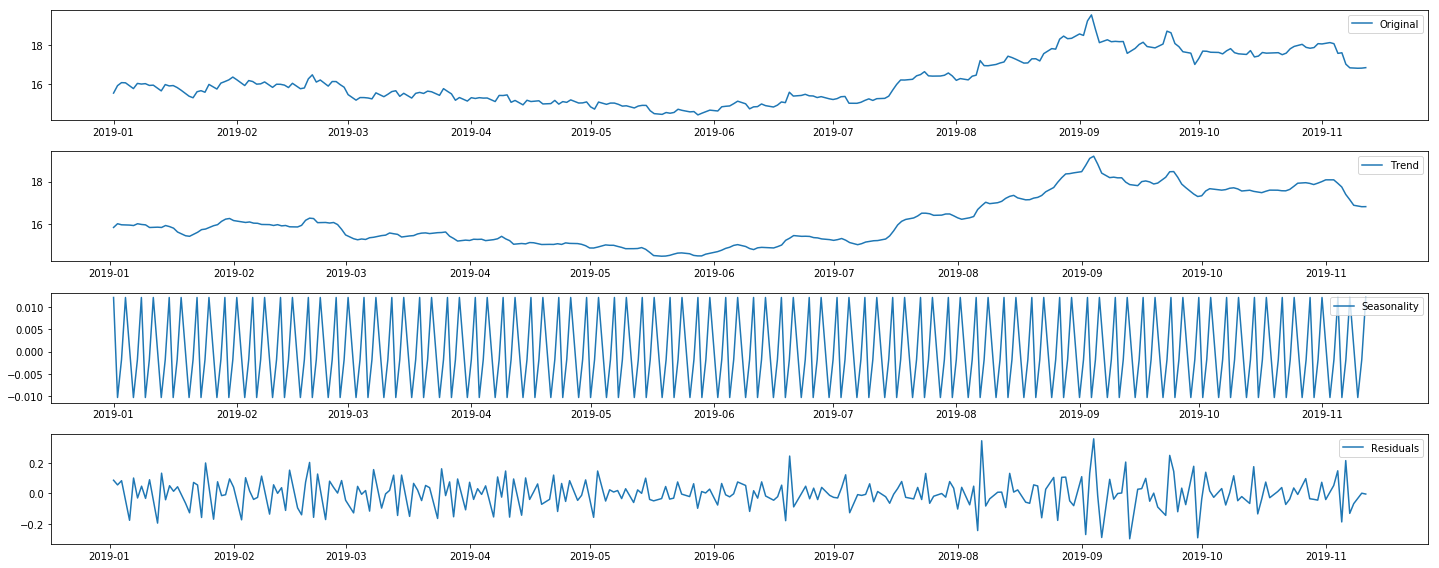

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(S_2019_S, freq=3)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(S_2019_S, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

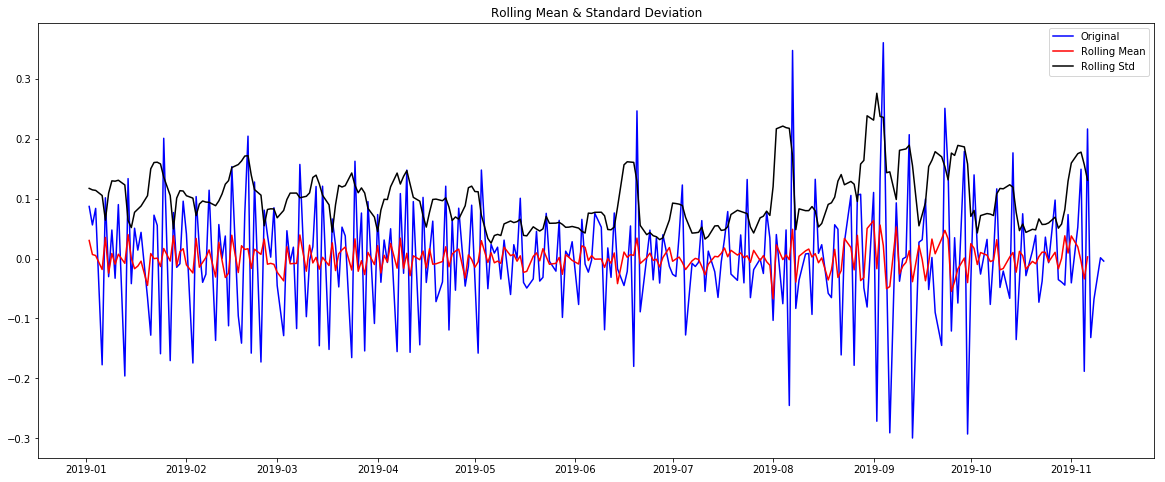

<Figure size 5760x720 with 0 Axes>

Results of Dickey-Fuller Test:
Test Statistic                -9.061574e+00
p-value                        4.548125e-15
#Lags Used                     1.600000e+01
Number of Observations Used    2.520000e+02
Critical Value (5%)           -2.873079e+00
Critical Value (1%)           -3.456569e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


In [0]:
S_2019_S_decompose = residual
S_2019_S_decompose.dropna(inplace=True)
test_stationarity(S_2019_S_decompose)

From above plot, we can see that by doing this seasonal decomposing, the price data is broken into trend, seasonality, and residuals. From the scale of each subplot, price has very small seasonality, which makes sense, since unlike other commodities that might have seasonality, gold's mined supply is essentially constant year-round. 

This [article](http://www.zealllc.com/2014/goldstse.htm) talks about potential seasonality in gold price data due to holidays in each country, for exmaple, in India, autumn is a popular season for weddings, where gold consumption usually ramps up there, while similarly for China, it will be during Jan or Feb when Spring festival comes. At this moment, I am not quite sure yet about how to interpret the seasonablity subplot; maybe it is related with weekly cycle, since every month seems having ~7 peaks. Based on the data, gold only has transactions during weekdays. This can be something interesting to look into but not in this analysis for now. 

# **4. Silver Price Prediction and Evaluation**

## **4.1 Linear Regression Model**



I want to first try the simpliest linear regression model to see how well it can perform. I am going to create new column features by using lagged moving average method. Since one assumption Linear regression method has is variables should be independent, meaning they should not be highly correlated. Thus depending on the correlation among the newly created features, I will remove some features. 

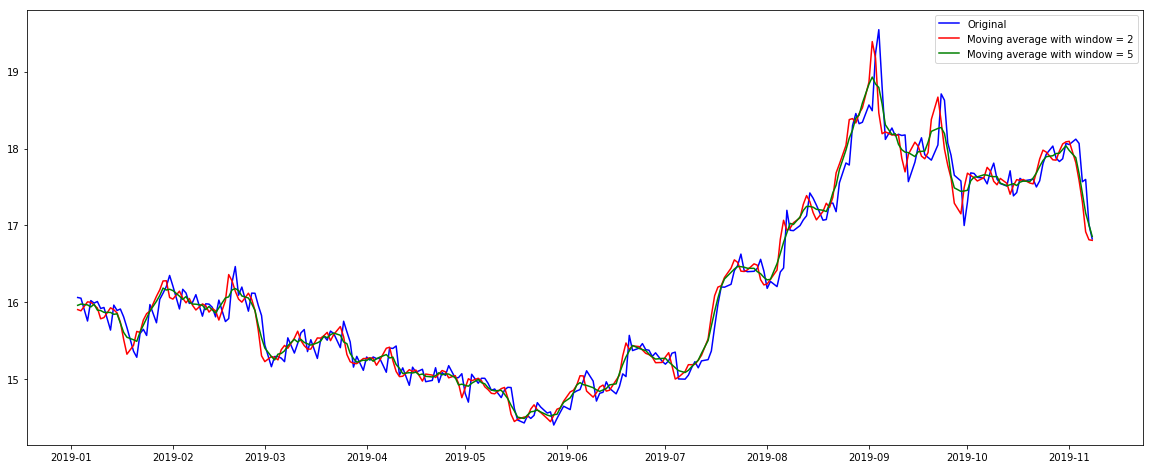

(266, 9)

In [0]:
#df.set_index('Date',inplace=True, drop=True)
# create two new columns with lagged terms with different moving window size 
df['S_1'] = df["Price"].shift(1).rolling(window=2, center = True).mean()
df['S_2'] = df["Price"].shift(1).rolling(window=5, center = True).mean()

# Define exploratory variables
# Finding moving average of past 2 day and 5 days 
df = df.dropna()
X = df[['S_1','S_2']]
X.head()
plt.plot(df['Date'], df['Price'], color="blue", label = "Original")
plt.plot(df['Date'], df['S_1'], color="red", label= "Moving average with window = 2")
plt.plot(df['Date'], df["S_2"],color="green", label= "Moving average with window = 5")
plt.legend(loc='best')
plt.show()

# dependent variable
y = df["Price"]
y.head()
df.shape

In [0]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,S_1,S_2
3,2019-11-08,16.823,17.070,17.095,16.66,135.57K,-1.10%,16.8050,16.8550
4,2019-11-07,17.010,17.605,17.645,16.91,166.41K,-3.34%,16.8125,17.0082
5,2019-11-06,17.598,17.555,17.630,17.36,101.43K,0.17%,16.9165,17.1602
6,2019-11-05,17.568,18.060,18.085,17.52,141.97K,-2.76%,17.3040,17.4130
7,2019-11-04,18.066,18.125,18.230,17.96,78.10K,-0.31%,17.5830,17.6728


('Silver Price =', -0.73, '* 2 Days Moving Average', 1.74, '* 12 Days Moving Average +', -0.07)


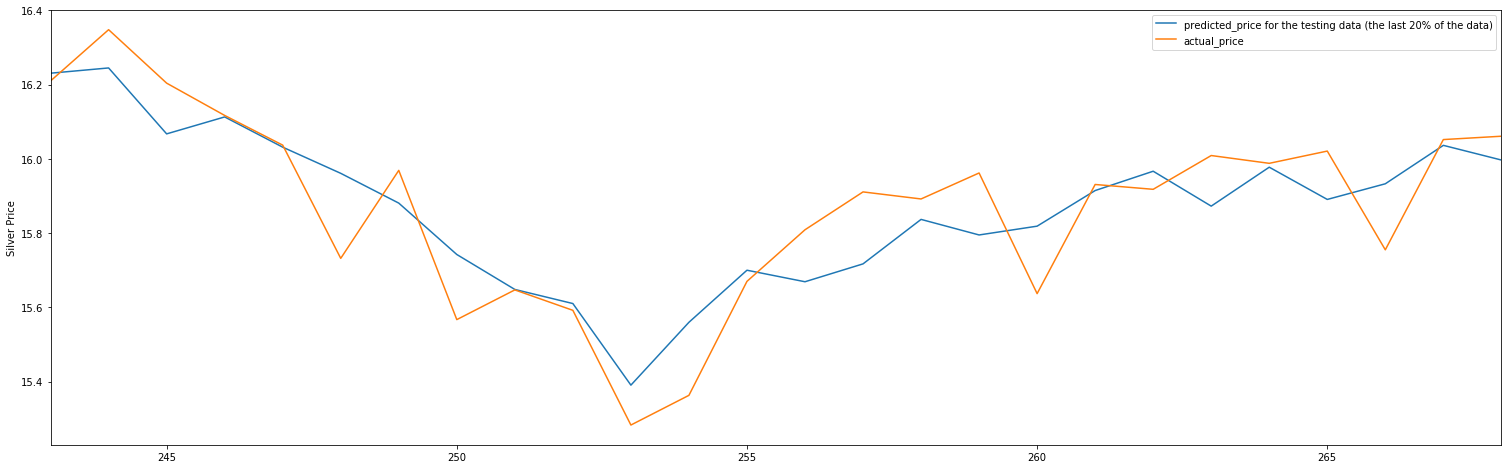

('R square for regression', 77.68)
The Mean Absolute Percentage Error for the forecast of time period from 2011-10-14 to 2019-11-12 is 0.60%


In [0]:
# Split into train and test

# training size 
t = 0.9

count = int(ceil(X.shape[0]*t))
X = X.iloc[::-1]
y = y.iloc[::-1]

X_train = X[:count]
X_test = X[count:]

y_train = y[:count]
y_test = y[count:]

# Performing linear regression
linear = LinearRegression().fit(X_train, y_train)

print("Silver Price =", round(linear.coef_[0], 2), "* 2 Days Moving Average", 
     round(linear.coef_[1], 2), "* 12 Days Moving Average +",
      round(linear.intercept_, 2))

# Predict prices
predicted_price = linear.predict(X_test)

predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])

predicted_price = pd.DataFrame(predicted_price,index=y_test.index,columns = ['price'])  
predicted_price.plot(figsize=(26,8)) 
y_test.plot()  
plt.legend(['predicted_price for the testing data (the last 20% of the data)','actual_price'])  
plt.ylabel("Silver Price")  
plt.show()


# Calculate R square and rmse to check goodness of fit
r2_score = linear.score(X_test, y_test)*100
print("R square for regression", float("{0:.2f}".format(r2_score)))

# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((y_test - predicted_price['price']) / y_test)) * 100
print('The Mean Absolute Percentage Error for the forecast of time period from 2011-10-14 to 2019-11-12 is {:.2f}%'.format(MAPE))


Above graph shows the test data, last 20% of the dataset, comparing the predicted price and actual price. R square is 78%, which is not bad, while Mean Absolute Percentage Error (MAPE) is 0.6%, which is small difference compared with actual price. 

Using the obtained linear coefficients between actual price and the two lagged terms, y_predicted = -0.73 * 2 days_moving_average + 1.74 * 12 days moving average - 0.07. This gives the next four days' prices' predictions: 18.04, 17.8, 17.5, and 17.3, which shows decreasing along the time.

From this [website](https://www.investing.com/commodities/gold-historical-data), the prices for Day 1 (November 13), and Day 4 (November 18, skippin) are  16.9, 17.03,and 16.9, from which we can see day 2 increased, but day 3 decreased. 

Observations for linear regression model: 

1) The model result is very sensitive to the choosing window size of the moving average. Perhaps some grid search can be done to seek the best window size. Also other tests, for examples, ridge regularization to avoid overfitting, can potentially be tried. In this analysis, my goal is use linear regression to see how it performs. 

2) This newly created lagged terms appear having high correlation with each other, which might violate the underline assumption of linear model that variables should be independent. Thus linear model is not a good choice to predict price if price is the only feature we know (other existing features, such as High, Low, and Open, are highly correlated with Price, almost 0.99). If we have other data sources, such as stock price, interest rate, and bond rate, linear regression would be a good method to explore the relations between the price and these additional features. If only using price informaiton, next I will try price forecasting using ARIMA model, which is one of the most commonly used model for time series model prediction. 

## **4.2 SARIMA Model**

In [0]:
# Create the p, d, q parameter for ARAM model
import itertools
#Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [0]:
# Sort the index
df2 = S_2019.sort_values('Date').set_index('Date')['Price']

In [0]:
df2.size

271

In [0]:
# Create train and test data
import numpy
train_data = df2[:244] #train data around 90%
test_data = df2[244:271] #test data around 10%

In [0]:
# Select the best fitting model by minimizing AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion)
import warnings
warnings.filterwarnings("ignore") 
import statsmodels.api as sm
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 6) - AIC:2040.3549515
SARIMAX(0, 0, 0)x(0, 0, 1, 6) - AIC:1693.74206546
SARIMAX(0, 0, 0)x(0, 1, 0, 6) - AIC:272.548670358
SARIMAX(0, 0, 0)x(0, 1, 1, 6) - AIC:270.215505687
SARIMAX(0, 0, 0)x(1, 0, 0, 6) - AIC:273.739837416
SARIMAX(0, 0, 0)x(1, 0, 1, 6) - AIC:270.739267731
SARIMAX(0, 0, 0)x(1, 1, 0, 6) - AIC:270.771802304
SARIMAX(0, 0, 0)x(1, 1, 1, 6) - AIC:272.104160991
SARIMAX(0, 0, 0)x(2, 0, 0, 6) - AIC:270.040845361
SARIMAX(0, 0, 0)x(2, 0, 1, 6) - AIC:271.191245267
SARIMAX(0, 0, 0)x(2, 1, 0, 6) - AIC:265.327903467
SARIMAX(0, 0, 0)x(2, 1, 1, 6) - AIC:260.58075196
SARIMAX(0, 0, 0)x(3, 0, 0, 6) - AIC:262.185799527
SARIMAX(0, 0, 0)x(3, 0, 1, 6) - AIC:257.875921167
SARIMAX(0, 0, 0)x(3, 1, 0, 6) - AIC:240.313586127
SARIMAX(0, 0, 0)x(3, 1, 1, 6) - AIC:241.982091014
SARIMAX(0, 0, 1)x(0, 0, 0, 6) - AIC:1711.37872981
SARIMAX(0, 0, 1)x(0, 0, 1, 6) - AIC:1373.7798032
SARIMAX(0, 0, 1)x(0, 1, 0, 6) - AIC:87.9722240201
SARIMAX(0, 0, 1)x(0, 1, 1, 6) - AIC:83.5572412946
SAR

In [0]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is -97.9344114172 for model SARIMAX(0, 1, 0)x(1, 0, 1, 6)


In [0]:
# Fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

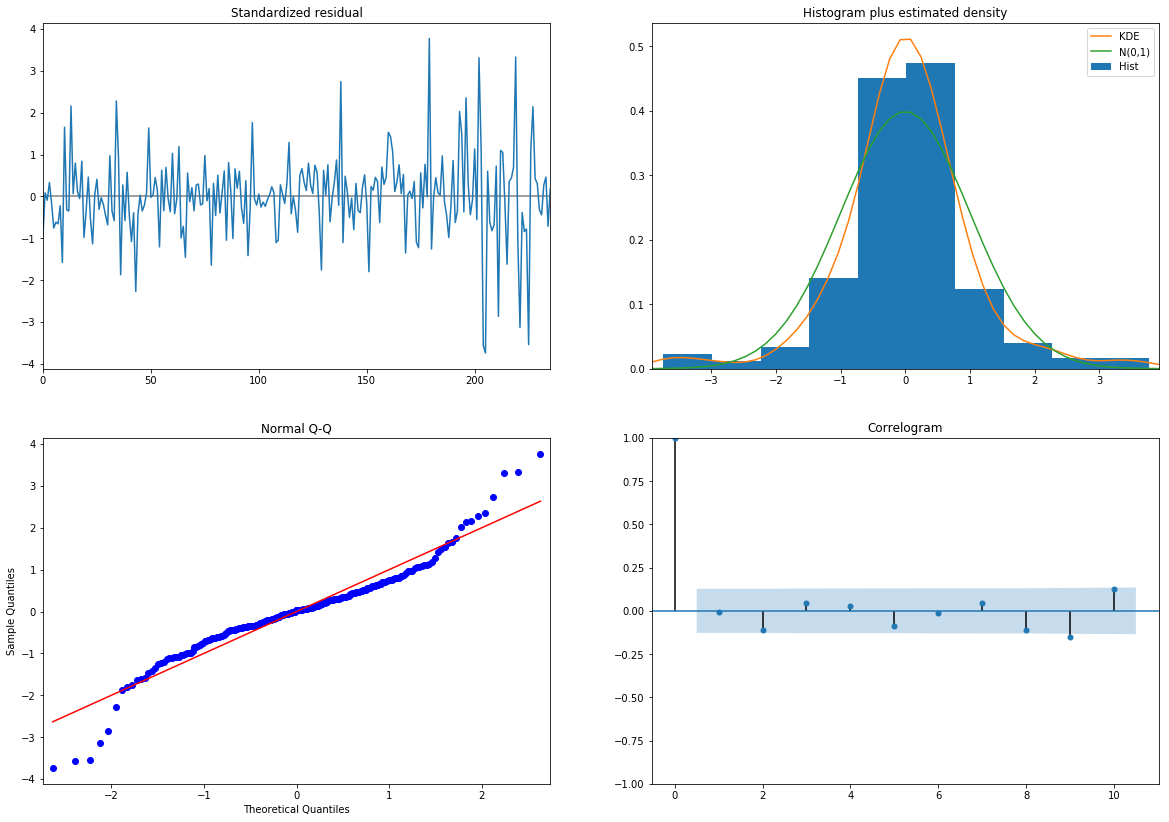

In [0]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [0]:
#predicted data with the same perid of test data
pred0 = results.get_forecast(steps=27)
pred0_ci = pred0.conf_int()

In [0]:
#predicted data 4 days out of sample
pred1 = results.get_forecast(steps=31)
pred1_ci = pred1.conf_int()
pred1.predicted_mean[-4:]

271    17.707850
272    17.650304
273    17.592944
274    17.618508
dtype: float64

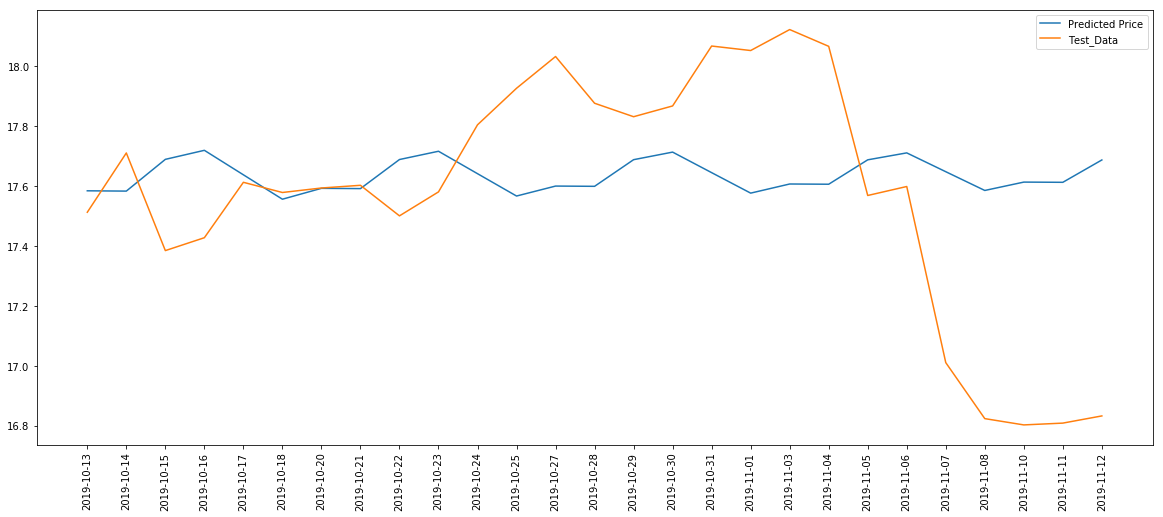

In [0]:
# Test data vs. predicted data
%matplotlib inline
x = test_data.index
y = pred0.predicted_mean
y1 = test_data
x2 = df2[:245].index
y2 = df2[:245]
plt.rcParams['figure.figsize'] = [20,8]
plt.plot(x, y, label='Predicted Price')
plt.plot(x, y1, label='Test_Data')
#plt.plot(x2, y2, label='Train_data')
plt.legend()
plt.xticks(rotation=90)
plt.show()

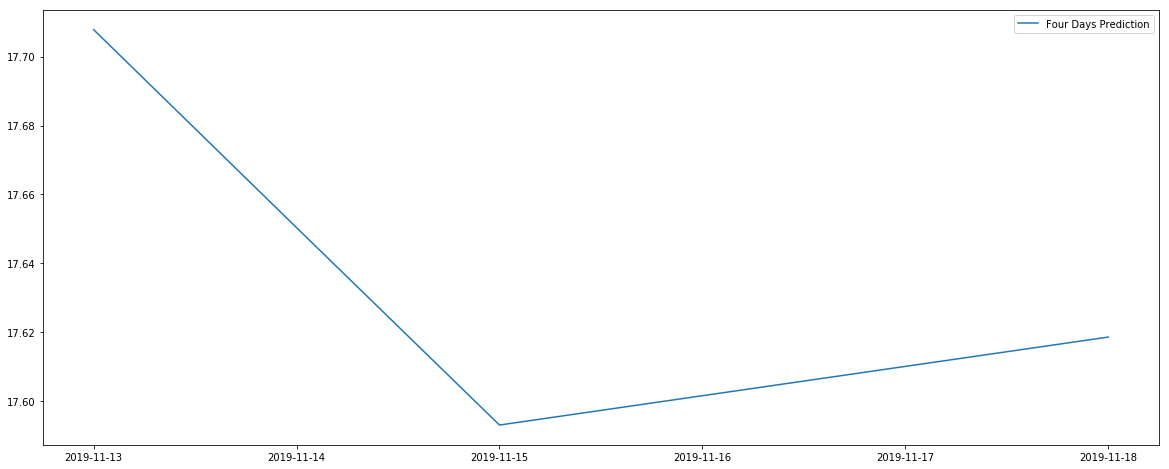

In [0]:
# Predicted price of silver in the next 4 days
plt.rcParams['figure.figsize'] = [20,8]
x3 = pd.DataFrame({'date': ['2019-11-13', '2019-11-14','2019-11-15','2019-11-18']})
y3 = pred1.predicted_mean[-4:]
plt.plot(pd.to_datetime(x3['date']), y3, label='Four Days Prediction')
plt.legend()
plt.show()

In [0]:
#evaluation
prediction = pred0.predicted_mean[:27].values
# flatten nested list
truth = (test_data.values)
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100
print('The Mean Absolute Percentage Error for the forecast of time period from2011-10-14 to 2019-11-12 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of time period from2011-10-14 to 2019-11-12 is 1.85%
